## Import Data + setup

In [193]:
import os.path as op
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as pyplot

import time

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc

#path_to_data = op.relpath("/modules/cs342/Assignment2/")
path_to_data = "./data"

start_time = time.time()

light_curves = pd.read_csv(path_to_data + "/training_set.csv")
metadata     = pd.read_csv(path_to_data + "/training_set_metadata.csv")

target = metadata["target"]
metadata = metadata.drop("target", axis=1)

metadata = metadata.drop(["ra", "decl", "gal_l", "gal_b", "distmod"], axis=1)

classes=np.array([6,15,16,42,52,53,62,64,65,67,88,90,92,95])

kf = KFold(n_splits=10, shuffle=True)

main_bands = ["u_band", "g_band", "r_band", "i_band", "z_band", "y_band"]


def num_to_desc(n):
    if n == 16: return "Galactic - Eclipsing System: " + str(n)
    if n == 92: return "Galactic - RR Lyrae (variable): " + str(n)
    if n == 53: return "Galactic - Cepheids: " + str(n)
    if n == 65: return "Galactic - Asteroids/flares: " + str(n)
    
    if n == 88: return "Extra Galactic - Active galactic nucleus (AGN): " + str(n)
    if n == 42 or n == 90 or n == 67 or n == 95 or n == 62 or n == 15 or n == 52 or n == 6:
        return "Extra Galatic - Burst event (Supernovae): " + str(n)
    
    return n

# drop flux error and detected flag for now
light_curves = light_curves.drop(["flux_err", "detected"], axis=1)

print time.time() - start_time

1.27438187599


## Reformat Data

In [242]:
training_set = metadata.copy()

curves_index = 0

start_time = time.time()

curves_subdf = pd.DataFrame(columns=main_bands, index=xrange(len(training_set)))

for i, current_id in enumerate(metadata["object_id"]):
    if i % 500 == 0: print i
    start_index = curves_index
    # remove gaps + set start to 0
    shift = light_curves.at[start_index,"mjd"]
    prev_row_mjd = shift
    while light_curves.at[curves_index,"object_id"] == current_id:
        this_row_mjd = light_curves.at[curves_index,"mjd"]
        if this_row_mjd - prev_row_mjd > 85:
            shift += gap-1
        light_curves.at[curves_index,"mjd"] -= shift
        curves_index += 1
        prev_row_mjd = this_row_mjd 
        if curves_index == len(light_curves):
            break

    sub_curves = light_curves.loc[start_index:curves_index-1, :].drop("object_id", axis=1)
    
    for k, band in enumerate(main_bands):
        curves_subdf.at[i,band] = sub_curves[sub_curves.passband == k].drop("passband", axis=1)
    
    
training_set = pd.concat([
    training_set,
    curves_subdf
], sort=False, axis=1).drop("object_id", axis=1)
    
print time.time() - start_time

0


KeyboardInterrupt: 

## find mean length in days

## Pre process

In [239]:
features_per_band = 60

def interpolate(time_series):
    places = np.linspace(0, time_series["mjd"].max(), features_per_band)
    ret = np.empty(features_per_band)
    i = 0
    for j, row in time_series.iterrows():
        if row["mjd"] >= places[i]:
            ret[i] = row["flux"]
            i += 1
    return ret

X = training_set[["ddf", "hostgal_specz", "hostgal_photoz", "hostgal_photoz_err", "mwebv"]].values

for band in main_bands:
    processed_X = np.empty((len(training_set), features_per_band))
    for i, row in training_set.iterrows():
        processed_X[i] = interpolate(row[band])
    X = np.append(X, processed_X, axis=1)

In [180]:
print len(training_set)

7848


## Train Random Forest

In [241]:
y = target.values
cross_scores = []

max_depths = [16]

for i, max_depth in enumerate(max_depths):

    model = RandomForestClassifier(n_estimators=140, max_depth=max_depth)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))

    cross_scores.append(np.mean(scores))
    print i, np.mean(scores)
    
print "="*20
print max_depths[np.argmax(cross_scores)], max(cross_scores)
    

0 0.6368542831145197
16 0.6368542831145197


## Plot Class dists

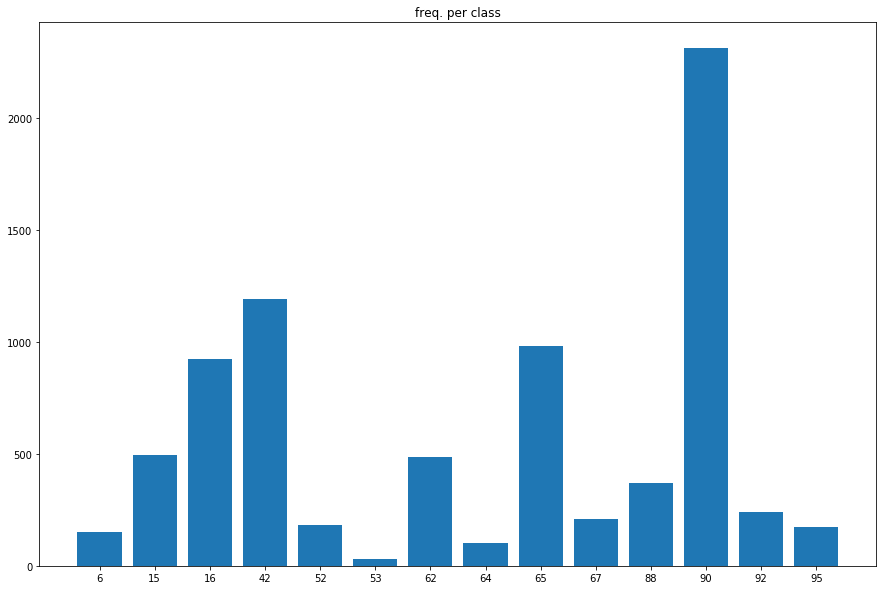

In [34]:
f, axes = pyplot.subplots(1,1)
f.set_size_inches(15,10)

frequencies = Counter(target)
frequencies = np.array([[frequencies.keys()[i], frequencies.values()[i]] for i in range(len(frequencies))])
frequencies = frequencies[np.argsort(frequencies[:,0])]

axes.bar([str(num) for num in frequencies[:,0]], frequencies[:,1])
axes.set_title("freq. per class");


## Plot Some Sample

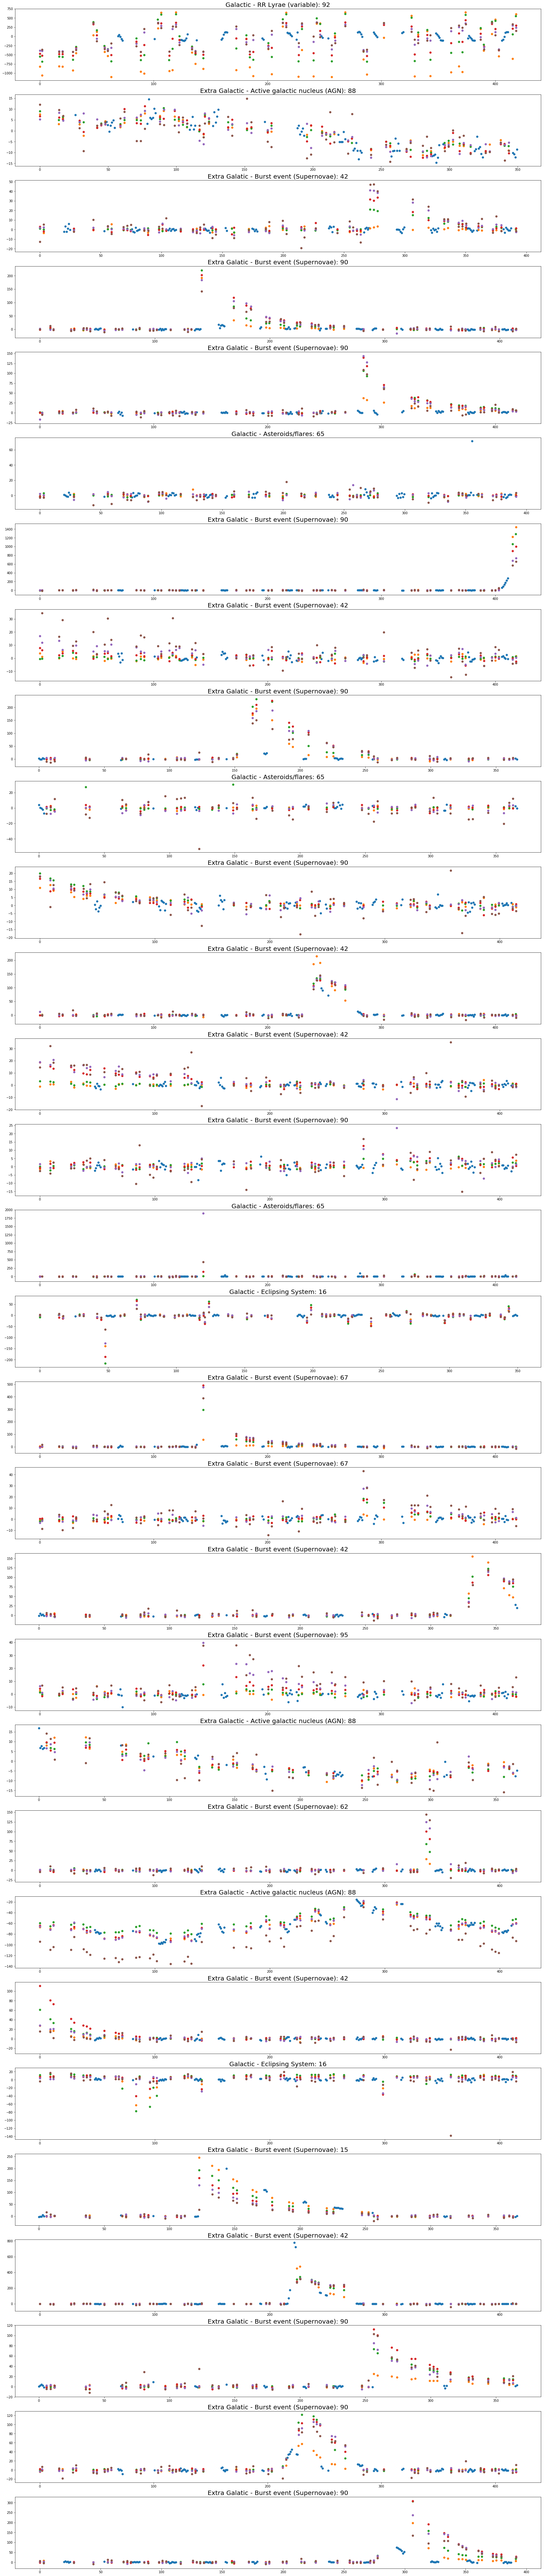

In [237]:
num_cases = 30
start_case = 0

f, axes = pyplot.subplots(num_cases, 1)
f.set_size_inches(30,5*num_cases)

for i in range(num_cases):
    index = start_case + i
    axes[i].set_title(num_to_desc(target.values[index]), fontsize=20)
    axes[i].set_facecolor((1.0,1.0,1.0,0.1))
    axes[i].scatter(training_set.at[index,"u_band"]["mjd"], training_set.at[index,"u_band"]["flux"])
    axes[i].scatter(training_set.at[index,"g_band"]["mjd"], training_set.at[index,"g_band"]["flux"])
    axes[i].scatter(training_set.at[index,"r_band"]["mjd"], training_set.at[index,"r_band"]["flux"])
    axes[i].scatter(training_set.at[index,"i_band"]["mjd"], training_set.at[index,"i_band"]["flux"])
    axes[i].scatter(training_set.at[index,"z_band"]["mjd"], training_set.at[index,"z_band"]["flux"])
    axes[i].scatter(training_set.at[index,"y_band"]["mjd"], training_set.at[index,"y_band"]["flux"])


## Plot Class Samples 

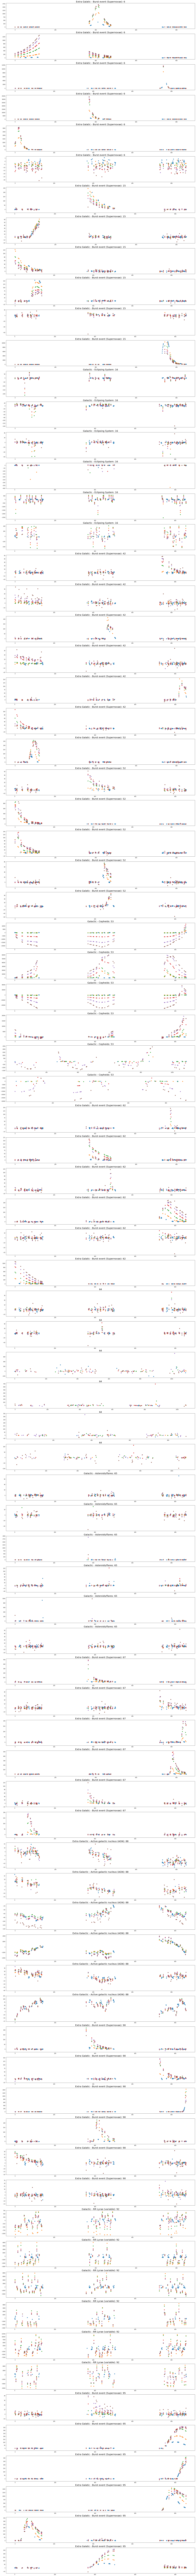

In [9]:
num_per_class = 6

f, axes = pyplot.subplots(num_per_class * len(classes), 1)
f.set_size_inches(30,5*num_per_class * len(classes))

i = 0
for class_num in classes:
    this_classes = training_set[training_set.target == class_num][0:num_per_class]
    for _, curves in this_classes.iterrows():        
        axes[i].set_facecolor((1.0,1.0,1.0,0.1))
        axes[i].set_title(num_to_desc(class_num), fontsize=20)
        axes[i].scatter(curves.at["u_band"][:,0], curves.at["u_band"][:,1])
        axes[i].scatter(curves.at["g_band"][:,0], curves.at["g_band"][:,1])
        axes[i].scatter(curves.at["r_band"][:,0], curves.at["r_band"][:,1])
        axes[i].scatter(curves.at["i_band"][:,0], curves.at["i_band"][:,1])
        axes[i].scatter(curves.at["z_band"][:,0], curves.at["z_band"][:,1])
        axes[i].scatter(curves.at["y_band"][:,0], curves.at["y_band"][:,1])
        i += 1 